## Load and set up images

In [1]:
%matplotlib widget
import numpy as np
import scipy
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
img_dir = "E:/research_data/2022_harmonic_gravity_waves/preprocessed_images/zooms/"
img_file = img_dir + "d20180114_t0500332_e0501573_b32203_c20220322202437972466_zoom.png"

In [4]:
img = Image.open(img_file).convert("L")
img_array = np.asarray(img, dtype='float64')
img_array_thresh = np.where(img_array >= 220, 0., img_array)

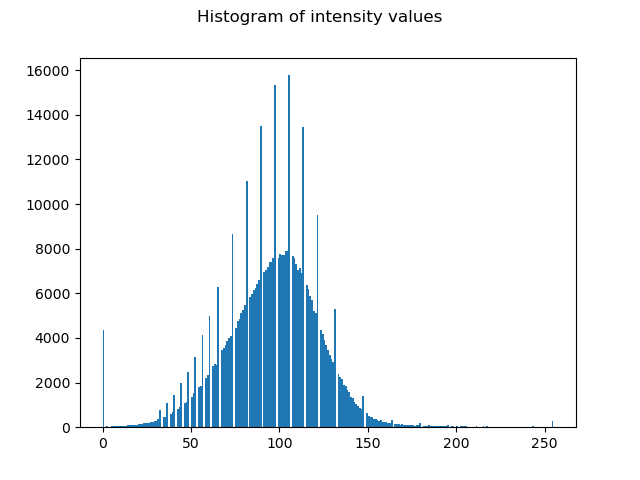

In [62]:
F, ax = plt.subplots()
F.suptitle("Histogram of intensity values")
ax.hist(img_array.ravel(), bins=255);

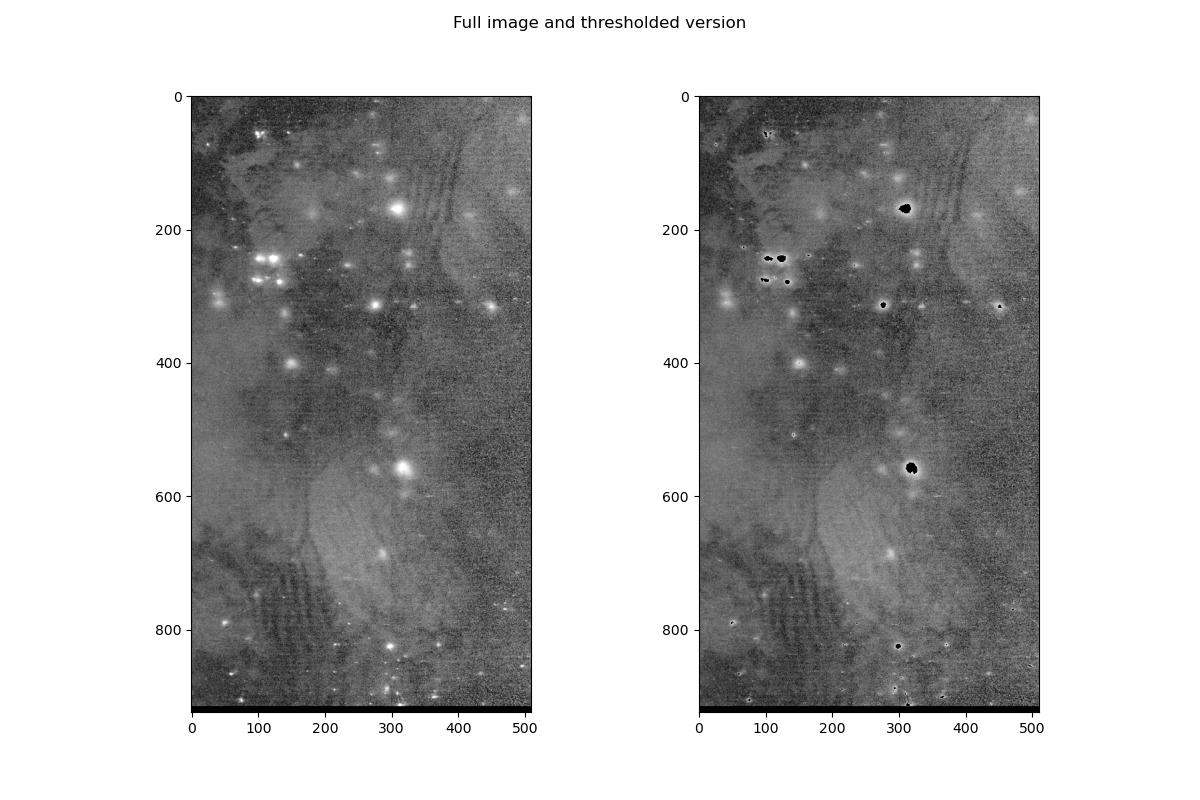

In [63]:
F, ax = plt.subplots(1, 2, figsize=(12, 8))
F.suptitle("Full image and thresholded version")
ax[0].imshow(img_array, cmap='gray', clim=(0, 255))
ax[1].imshow(img_array_thresh, cmap='gray', clim=(0, 255))

In [10]:
img_crop = img_array[67:230, 328:414]
img_crop_thresh = img_array_thresh[67:230, 328:414]

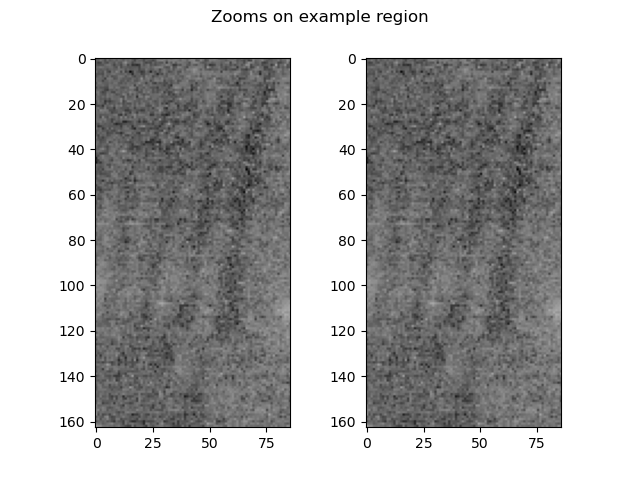

In [64]:
F, ax = plt.subplots(1, 2)
F.suptitle("Zooms on example region")
ax[0].imshow(img_crop, cmap='gray', clim=(0, 255))
ax[1].imshow(img_crop_thresh, cmap='gray', clim=(0, 255))

## Set up autocorrelation functions

In [90]:
def auto_correlate(img, x, y, width, height, xrange=None, yrange=None):
    if xrange==None:
        xrange = width//2
    if yrange==None:
        yrange = height//2
        
    img_crop = np.copy(img[y:y+height, x:x+width])
    
    normalizer_1 = np.mean(np.abs(img_crop))
    
    full_xrange = range(0, 2*xrange)
    full_yrange = range(0, 2*yrange)
    
    corr_img = np.zeros((len(full_yrange), len(full_xrange)))
    
    for xt in full_xrange:
        for yt in full_yrange:
            x_ref = x + (xt - xrange)
            y_ref = y + (yt - yrange)
            img_comp = np.copy(img[y_ref:y_ref+height, x_ref:x_ref+width])
            normalizer_2 = np.mean(np.abs(img_comp))
            corr_img[yt, xt] = np.sum(img_comp * img_crop) / (width * height * normalizer_1 * normalizer_2)
    
    corr_img[yrange, xrange] = np.NaN
            
    return corr_img

In [126]:
def local_auto_corr(img, xnum, ynum):
    width = img.shape[1] // (xnum + 1)
    height = img.shape[0] // (ynum + 1)
    
    x_vals = [width // 2 + i * width for i in range(xnum)]
    y_vals = [height // 2 + i * height for i in range(ynum)]
    
    corr_im = np.full(img.shape, np.NaN)
    
    for x in x_vals:
        for y in y_vals:
            corr_im_temp = auto_correlate(img, x, y, width, height)
            corr_im[y:y+corr_im_temp.shape[0], x:x+corr_im_temp.shape[1]] = corr_im_temp
            
    return corr_im

## Run autocorrelation on test region

In [96]:
corr_img = auto_correlate(img_array.astype('float64'), 328, 67, 86, 163, yrange=67)
corr_img_thresh = auto_correlate(img_array_thresh, 328, 67, 86, 163, yrange=67)

In [97]:
vmin = min([np.nanmin(corr_img), np.nanmin(corr_img_thresh)])
vmax = max([np.nanmax(corr_img), np.nanmax(corr_img_thresh)])

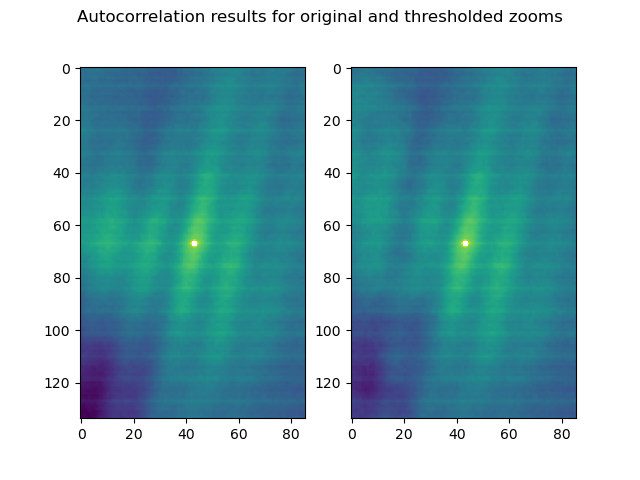

In [98]:
F, ax = plt.subplots(1, 2)
F.suptitle("Autocorrelation results for original and thresholded zooms")
ax[0].imshow(corr_img, cmap='viridis', clim=(vmin, vmax))
ax[1].imshow(corr_img_thresh, cmap='viridis', clim=(vmin, vmax))

## Autocorrelate entire image

In [127]:
corr_im = local_auto_corr(img_array, 10, 20)

C:\Users\lande\.conda\envs\harmonic_gw\lib\site-packages\matplotlib\axes\_axes.py:6677: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\lande\.conda\envs\harmonic_gw\lib\site-packages\matplotlib\axes\_axes.py:6678: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


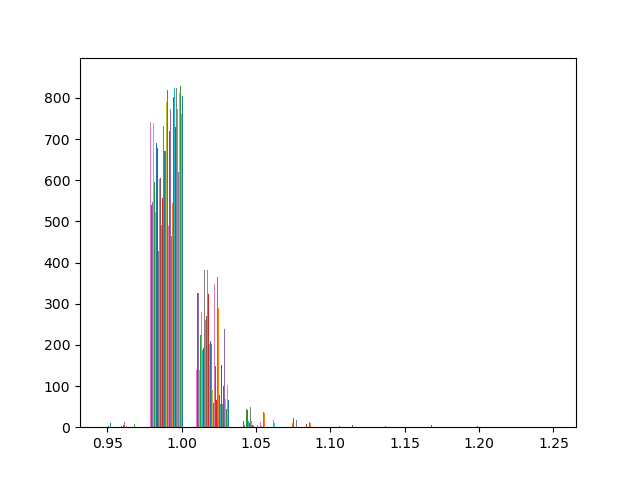

In [128]:
F, ax = plt.subplots()
ax.hist(corr_im);

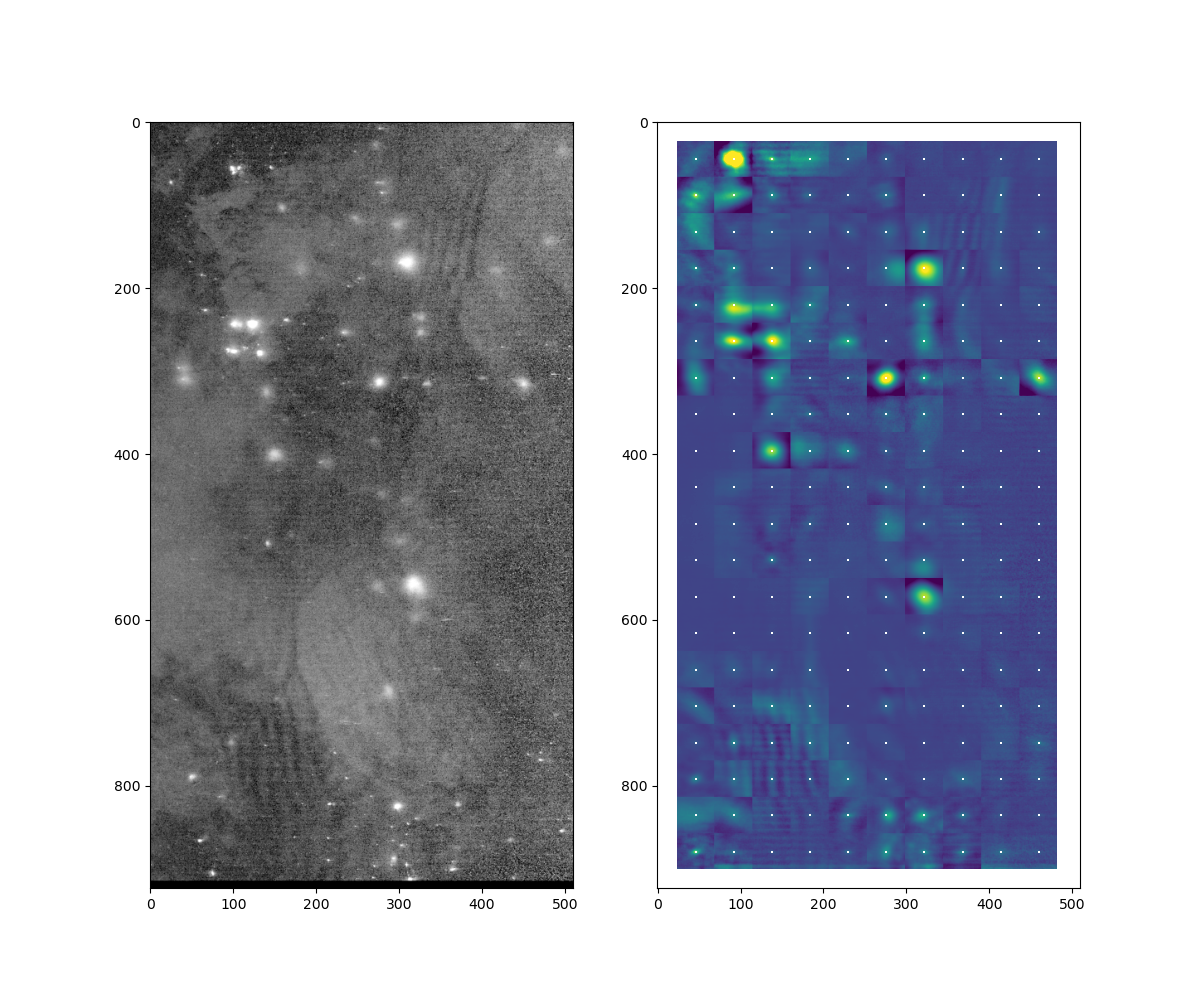

In [137]:
F, ax = plt.subplots(1, 2, figsize=(12, 10))
ax[0].imshow(img_array, cmap='gray', clim=(0, 255))
ax[1].imshow(corr_im, clim=(0.9779, 1.0882))

In [131]:
corr_im_thresh = local_auto_corr(img_array_thresh, 10, 20)

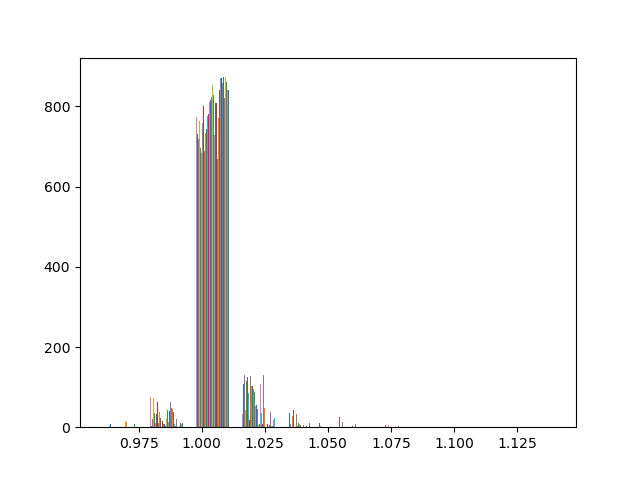

In [132]:
F, ax = plt.subplots()
ax.hist(corr_im_thresh);

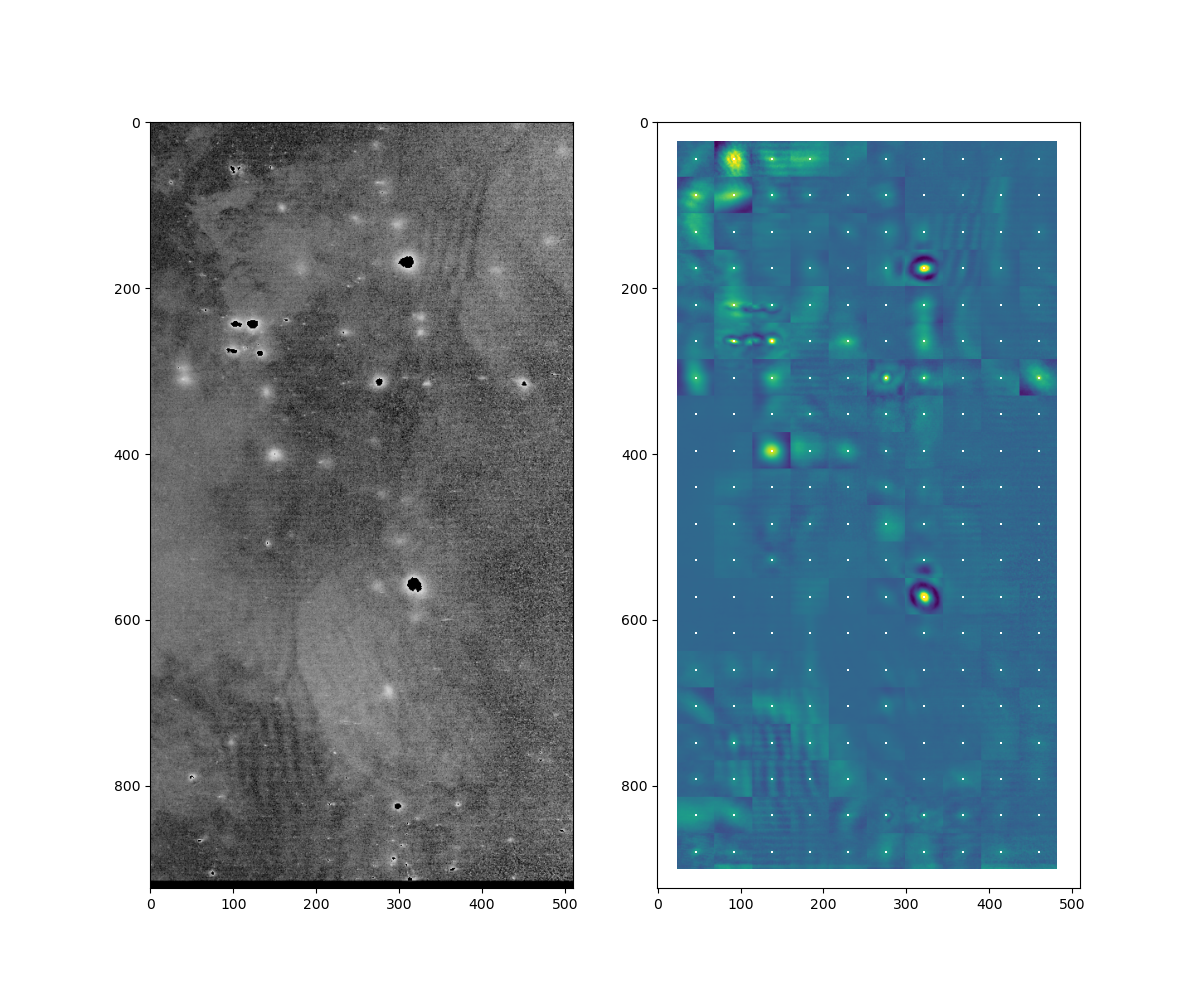

In [139]:
F, ax = plt.subplots(1, 2, figsize=(12, 10))
ax[0].imshow(img_array_thresh, cmap='gray', clim=(0, 255))
ax[1].imshow(corr_im_thresh, clim=(0.9624, 1.077))

## Synthetic image to test autocorrelation

In [84]:
x = np.linspace(0, 60, 1000)
xdat = np.sin(x)
temp_im = np.stack([xdat]*1000)

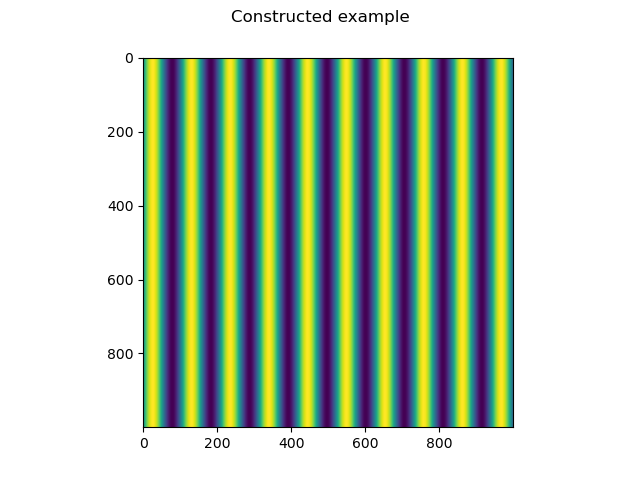

In [66]:
F, ax = plt.subplots()
F.suptitle("Constructed example")
ax.imshow(temp_im)

In [22]:
corr_im = auto_correlate(temp_im, 400, 400, 200, 200)

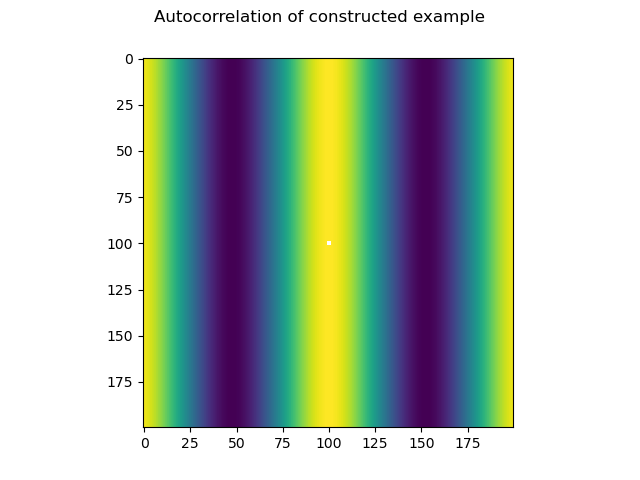

In [67]:
F, ax = plt.subplots()
F.suptitle("Autocorrelation of constructed example")
ax.imshow(corr_im)

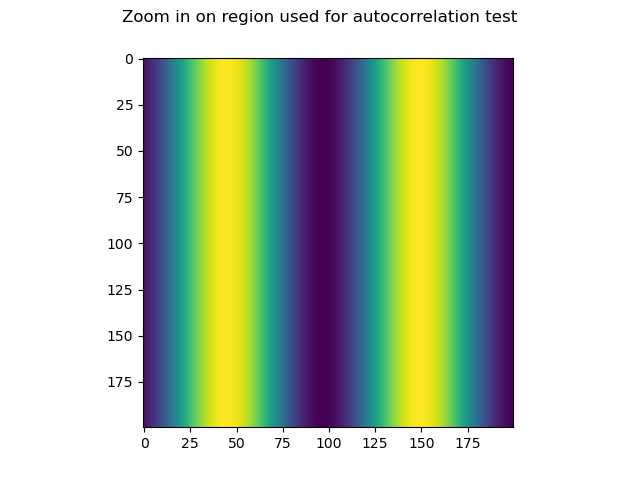

In [68]:
F, ax = plt.subplots()
F.suptitle("Zoom in on region used for autocorrelation test")
ax.imshow(temp_im[400:600, 400:600])

## Try Fourier-based autocorrelation

In [70]:
f_img_crop = scipy.fft.fft(img_crop)

In [71]:
power_spec = (np.abs(f_img_crop))**2

In [72]:
img_crop_corr = np.abs(scipy.fft.fft(power_spec))

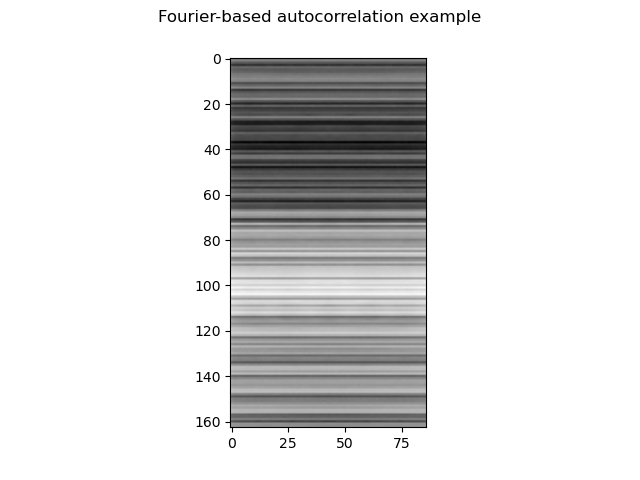

In [73]:
F, ax = plt.subplots()
F.suptitle("Fourier-based autocorrelation example")
ax.imshow(img_crop_corr, cmap='gray')